# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


<h2>Задание 1.</h2>

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: <b>a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.</b> Значимы ли полученные результаты с практической точки зрения ?

In [4]:
#данные для вернувших и не вернувших кредит
data_return = data[data.default==0]
data_no_return = data[data.default==1]

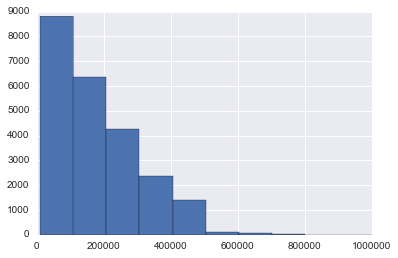

In [5]:
data_return.LIMIT_BAL.hist()

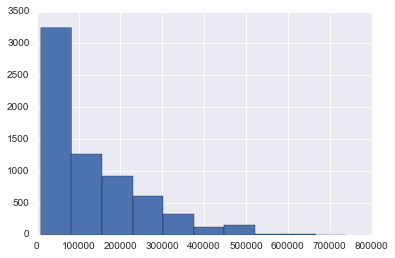

In [6]:
data_no_return.LIMIT_BAL.hist()

На графиках заметно отличие между гистограммами для двух категорий.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

return_median = map(np.median, get_bootstrap_samples(data_return.LIMIT_BAL.values, 1000))
no_return_median = map(np.median, get_bootstrap_samples(data_no_return.LIMIT_BAL.values, 1000))

In [10]:
print "95% confidence interval for the LIMIT_BAL median (default = 0):",  stat_intervals(return_median, 0.05)
print "95% confidence interval for the LIMIT_BAL median (default = 1):",  stat_intervals(no_return_median, 0.05)

95% confidence interval for the LIMIT_BAL median (default = 0): [ 150000.  150000.]
95% confidence interval for the LIMIT_BAL median (default = 1): [ 80000.  90000.]


Доверительные интервалы не пересекаются. <b>Медианные значения значительно отличаются.</b>

In [13]:
#критерий Манна-Уитни в таком формате, т.к. версия scipy почему-то содержит кривую функцию для него
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        pass

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = scipy.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = scipy.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * scipy.stats.distributions.norm.sf(abs(z))
    else:
        p = scipy.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)

Критерий Манна-Уитни:

- H_0 - отличий нет
- H_1 - отличия есть

p = 0.05

In [14]:
mannwhitneyu(data_return.LIMIT_BAL.values, data_no_return.LIMIT_BAL.values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

<b>Нулевая гипотеза отвергается на уровне 0.05. Отличие значимо.</b>

Практическая польза состоит в выдаче кредитов меньшего размера для тех, кто его не выдает, что снижает издержки банка. Впрочем, это уже реальные данные, и сложно говорить о практической значимости таких наблюдений, т.к. банк должен оценивать кредитоспособность заемщика. А это значит, что банк изначально выдавал меньшие суммы тем, у кого меньше вероятность выплаты кредита. Мы лишь убедились в этом на полученных результатах.

<h2>Задание 2.</h2>

Пол (SEX): <b>Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.</b> Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

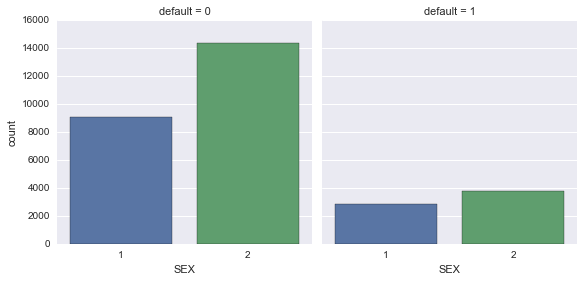

In [15]:
sns.factorplot('SEX', col='default', data=data, kind='count')

Похоже, что доля женщины чаще возвращают кредиты (их доля среди плательщиков визуально больше).

<h2>Доверительный интервал для доли:</h2>

In [21]:
from statsmodels.stats.proportion import proportion_confint

In [27]:
# посмотрим, отличается ли доля невыплат для мужского пола
normal_interval_return = proportion_confint(len(data_return[data_return.SEX==1]), len(data_return), method = 'normal')
normal_interval_no_return = proportion_confint(len(data_no_return[data_no_return.SEX==1]), len(data_no_return), method = 'normal')

In [28]:
print 'normal_interval [%f, %f] for returned' % (normal_interval_return[0],
                                                  normal_interval_return[1])

print 'normal_interval [%f, %f] for no returned' % (normal_interval_no_return[0],
                                                  normal_interval_no_return[1])

normal_interval [0.379608, 0.392092] for returned
normal_interval [0.421020, 0.444863] for no returned


Интервалы не перекрывают друг друга. Доля невыплат у мужчин отличается

<h2>Критерий Фишера:</h2>

Критерий Фишера:
- H_0 - независимы
- H_1 - зависимы

p = 0.05

In [17]:
subtable = [[data_no_return.SEX.value_counts()[1], data_no_return.SEX.value_counts()[2]],
         [data_return.SEX.value_counts()[1], data_return.SEX.value_counts()[2]]]

In [20]:
scipy.stats.fisher_exact(subtable)

(1.215226725941307, 5.2528380520807031e-12)

<b>Нулевая гипотеза отвергается на уровне 0.05. Получаем, что испытания зависимы.</b> То есть пол влияет на невыплату.

<h2>Задание 3.</h2>

Образование (EDUCATION): <b>Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.</b> Предложите способ наглядного представления практической значимости разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

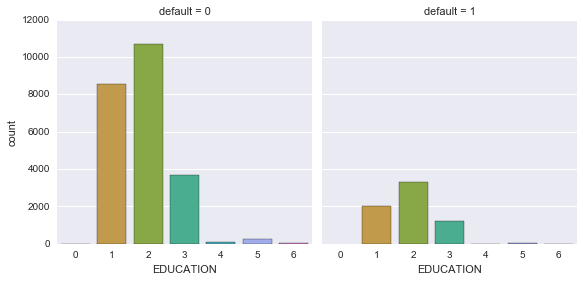

In [29]:
sns.factorplot('EDUCATION', col='default', data=data, kind='count')

Очень сложно инерпретировать такой график. Нужен более грубокий анализ.

In [30]:
# посчитаем критерий хи-квадрат и фишера для пар значений (образоавание + вернул/нет)
ed = [0,1,2,3,4,5,6]
for i in ed:
        subtable = [[len(data_return[data_return.EDUCATION==i]), len(data_return)],
                   [len(data_no_return[data_no_return.EDUCATION==i]), len(data_no_return)]]
        print "таблица сопряженности:", subtable
        g, p, dof, expctd = scipy.stats.chi2_contingency(subtable, correction=True)
        oddsratio, pvalue = scipy.stats.fisher_exact(subtable)
        print "образование, значимость:", i, pvalue, p
        print "доля людей с таким образованием среди плательщиков и неплательщиков:", float(subtable[0][0])/subtable[0][1], float(subtable[1][0])/subtable[1][1]

таблица сопряженности: [[14, 23364], [0, 6636]]
образование, значимость: 0 0.0502870583024 0.0945509805328
доля людей с таким образованием среди плательщиков и неплательщиков: 0.000599212463619 0.0
таблица сопряженности: [[8549, 23364], [2036, 6636]]
образование, значимость: 1 3.77723610836e-10 5.21622580965e-10
доля людей с таким образованием среди плательщиков и неплательщиков: 0.36590481082 0.306811332128
таблица сопряженности: [[10700, 23364], [3330, 6636]]
образование, значимость: 2 0.000167200499681 0.000169373227603
доля людей с таким образованием среди плательщиков и неплательщиков: 0.457969525766 0.501808318264
таблица сопряженности: [[3680, 23364], [1237, 6636]]
образование, значимость: 3 2.9092469394e-06 2.5250151748e-06
доля людей с таким образованием среди плательщиков и неплательщиков: 0.157507276151 0.186407474382
таблица сопряженности: [[116, 23364], [7, 6636]]
образование, значимость: 4 1.01173944182e-06 1.89635638527e-05
доля людей с таким образованием среди плательщи

На уровне значимости 0.05 получаем, что статистически не значимы только различия для групп выплат и не выплат только <b>ученая степень и отсутствие информации об образовании</b>. Для остальных групп получим,<i> что магистерская степерь и образование, которое помечено, как прочее, повышает шансы на выплату, а начальное образование и степеь бакалавра понижают шансы на выплату.</i>

В качестве практической иллюстрации можно посчитать суммарные потери от невыплат по группам образования.

<h2>Задание 4.</h2>

Семейное положение (MARRIAGE): <b>Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.</b>

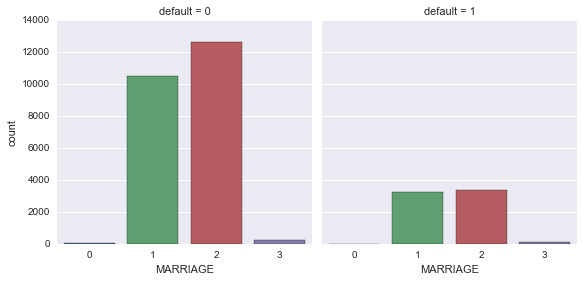

In [32]:
sns.factorplot('MARRIAGE', col='default', data=data, kind='count')

Визуально есть разница между долей холостых по отношению к другим для неплательщиков. Но в целом, по группе, не очень заметна какая-либо тенденция.

В качестве критерия возможной связи, предлагаю использовать <b>V Крамера</b>. Посчитаем ее.

In [33]:
def proportions_diff_confint_ind(p1, p2, l1, l2, alpha = 0.05):    
    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    print p1 * (1 - p1)/ l1,  p2 * (1 - p2)/ l2
    
    print np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    return (left_boundary, right_boundary)

In [34]:
def proportions_diff_z_stat_ind(p1, p2, n1, n2):

    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [35]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [36]:
marriage = [[len(data_return[data_return.MARRIAGE==0]),len(data_return[data_return.MARRIAGE==1]),
             len(data_return[data_return.MARRIAGE==2]),len(data_return[data_return.MARRIAGE==3])],
            [len(data_no_return[data_no_return.MARRIAGE==0]),len(data_no_return[data_no_return.MARRIAGE==1]),
             len(data_no_return[data_no_return.MARRIAGE==2]),len(data_no_return[data_no_return.MARRIAGE==3])]]

In [37]:
from scipy.stats import chi2_contingency

In [38]:
round(np.sqrt(chi2_contingency(marriage)[0]/(np.sum(marriage)*2)),4)

0.0244

Похоже, что связь между семейным положением и выплатой или невыплатой кредита <b>практически отсутствует</b>.

<h2>Задание 5.</h2>

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: <b>a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.</b> Значимы ли полученные результаты с практической точки зрения ?

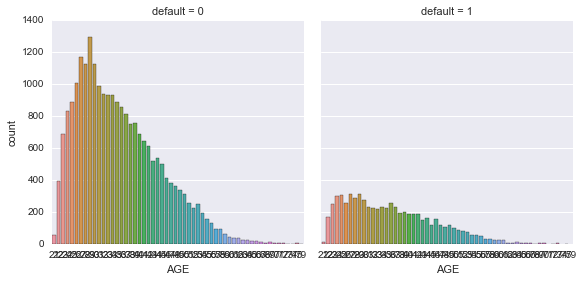

In [39]:
sns.factorplot('AGE', col='default', data=data, kind='count')

График для плтельщиков кажется более крутым, чем для неплательщиков. Но нужен дополнительный алализ.

In [40]:
np.random.seed(0)

age_return_median = map(np.median, get_bootstrap_samples(data_return.AGE.values, 1000))
age_no_return_median = map(np.median, get_bootstrap_samples(data_no_return.AGE.values, 1000))

In [45]:
print "95% confidence interval for the AGE median (default = 0):",  stat_intervals(age_return_median, 0.05)[0], stat_intervals(age_return_median, 0.05)[1]
print "95% confidence interval for the AGE median (default = 1):",  stat_intervals(age_no_return_median, 0.05)[0], stat_intervals(age_no_return_median, 0.05)[1]

95% confidence interval for the AGE median (default = 0): 34.0 34.0
95% confidence interval for the AGE median (default = 1): 34.0 35.0


Доверительные интервалы пересекаются. Можно сказать, что <b>медианные возрасты не отличаются для двух групп заемщиков.</b>

Критерий Манна-Уитни:

- H_0 - отличий нет
- H_1 - отличия есть

p = 0.05

In [47]:
mannwhitneyu(data_return.AGE.values, data_no_return.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

<b>Нулевая гипотеза не отвергается на уровне 0.05. Отличие не значимо.</b>

Похоже, что влияние возраста оказалось незначимо статистически. В любом случае, <b>не похоже, что возраст мог иметь и большую практическую значимость, учитывая, что он примерно похож для обеих групп</b>. Если бы отличие было бы <b>кардинальным</b> (к примеру, пенсионеры платили бы лучше), то можно было бы пытаться извлечь практическую значимость из возраста, но, как мы можем видеть, медианный возраст в обеих группах примерно соответствует 34-35 годам. 